In [1]:
%matplotlib inline

# 大藝術家(pytorch)

![style transfer](Images/styletransfer.png)

In [2]:
import time
import os 
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict


In [3]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\dell/.torch\models\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████| 574673361/574673361 [04:19<00:00, 2214535.56it/s]


In [21]:

def array2img(arr: np.ndarray):
    sanitized_img =arr[::-1]* np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    sanitized_img = np.maximum(0, np.minimum(255, np.transpose(arr, (1, 2, 0))))#轉成HWC
    
    img = Image.fromarray(sanitized_img.astype(np.uint8))
    return img

def imshow(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    plt.imshow(image)
    
def load_image(img_path, max_size=256, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    # Large images will kill your computer so keep them reasonable
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # Discard alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [5]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    # To get the layer outputs we need to pass the image forward through the network 
    # until we get to a desired layer and get the output from that layer
    
    # Mapping layer names of PyTorch's VGGNet to layer names from the paper
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

# #定義Gram Matrix

In [6]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a tenser 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # Batch, channels, height, width
    _, c, h, w = tensor.size()
    
    # Reshape so we're multiplying the features for each channel
    tensor = tensor.view(c, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

![style all](Images/style_all.jpg)

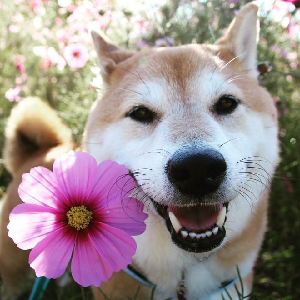

In [7]:
content_path = 'Images/dog.jpg'
content_image=Image.open( content_path).resize((300,300))
content_image

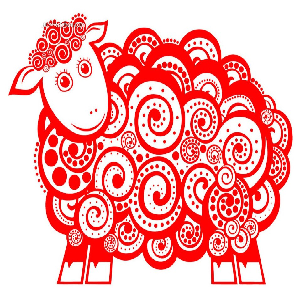

In [8]:
style_path = 'Images/style6.jpg'
style_image=Image.open(style_path).resize((300,300))
style_image

In [9]:
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device).eval()
content = load_image(content_path).to(device)
# Resize style to match content, makes code easier
style = load_image(style_path, shape=content.shape[-2:]).to(device)

# Calculate content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

Iteration: 101, loss: 2825827.750000
torch.Size([3, 256, 256])


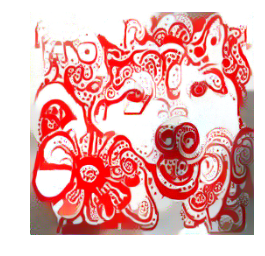

Iteration: 201, loss: 2812216.750000
torch.Size([3, 256, 256])


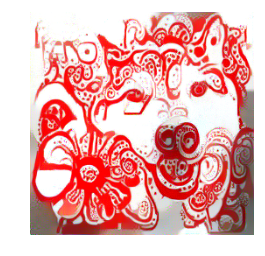

Iteration: 301, loss: 2795827.500000
torch.Size([3, 256, 256])


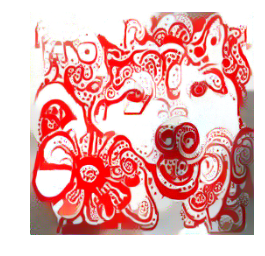

Iteration: 401, loss: 2777564.750000
torch.Size([3, 256, 256])


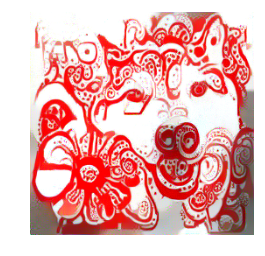

Iteration: 501, loss: 2757872.250000
torch.Size([3, 256, 256])


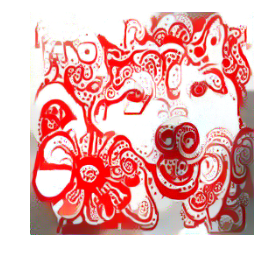

In [24]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

optimizer = optim.Adam([target], lr=0.003)

steps = 500
content_weight = 1
style_weight = 1e6
tv_weight = 1e-6
show_every = 100

for ii in range(1, steps+1):
    
    style_loss = 0
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # Style loss now
    for layer in style_weights:
        target_feature = target_features[layer]
        _, c, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        style_loss += style_weights[layer] * torch.mean((target_gram - style_gram)**2) / (c * h * w)
        
    # Total variational loss, reduces noise in the image
    diff_i = torch.sum(torch.abs(target[:, :, :, 1:] - target[:, :, :, :-1]))
    diff_j = torch.sum(torch.abs(target[:, :, 1:, :] - target[:, :, :-1, :]))
    tv_loss = (diff_i + diff_j)
    
    total_loss = content_weight * content_loss + style_weight * style_loss + tv_weight * tv_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if  ii % show_every == 0:
        print('Iteration: %d, loss: %f'%( ii+1, total_loss.item()))
        print(target[0].shape)
        target_img=array2img(target.cpu().detach().numpy()[0])
        target_img.save('Results/dog_pytorch_{0}.jpg'.format( ii//show_every ))
        imshow(target)
        plt.axis('off')
        plt.show()

In [ ]:

fig = plt.figure(figsize=(8,8))
plt.axis('off')
imshow(target)